# Text Analysis of NeurIPS Papers

In this notebook we will perform text analysis of a collection of papers from Neural Information Processing Systems (NeurIPS) conferences. These papers cover topics of machine learning and neuroscience with publication years ranging from 1987-2019. The data come from the following source:

https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated?select=papers.cs

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation as LDA
from scipy.cluster import hierarchy

## Data Processing

In [2]:
# load corpus, drop empty documents
corpus = pd.read_csv('papers.csv')
corpus = corpus.dropna(subset=['full_text']).reset_index(drop=True)

In [4]:
# compute X, matrix of word counts
# only using top 4000 words
vectorizer = CountVectorizer(stop_words = 'english', max_features=4000)
X = vectorizer.fit_transform(corpus.full_text.values)

In [5]:
# convert X to tfidf values
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(X)

## Principal Component Analysis

In [6]:
# pca dimension reduction
pca = PCA(n_components=100)
pca.fit(tfidf.toarray())

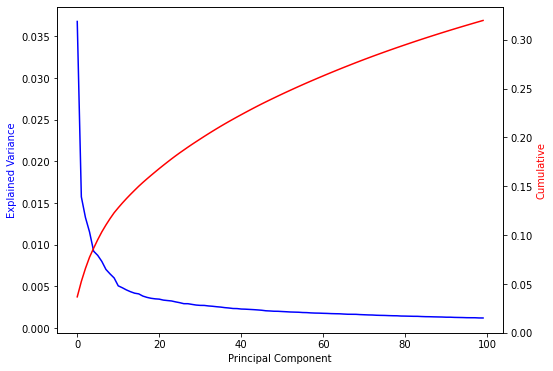

In [301]:
# plot explained variance of components
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(np.arange(pca.n_components_), 
         pca.explained_variance_,
         color='blue')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance',
              color='blue')

ax2 = ax1.twinx()
ax2.plot(np.arange(pca.n_components_), 
         pca.explained_variance_.cumsum(),
         color='red')
ax2.set_ylabel('Cumulative',
              color='red')
ax2.set_ylim(0);

In [7]:
# project data along components
transformed = pca.transform(tfidf.toarray())

In [276]:
# create df for plotting, needs all PCs and metadata
plot_data = corpus.drop('full_text', axis=1)
plot_data = plot_data.join(
    pd.DataFrame(
        {f'PC{i}':pc for i,pc in enumerate(transformed.T)}
    )
)

In [277]:
''' Plot transformation by specified pca comps
INPUT
    data: the transformed dataframe with labels year, PC{i}
    a: PC for x-axis
    b: PC for y-axis
    hue: color for plotting
    sample: optional, only use this many samples from data
OUTPUT
    None
'''
def plot_comps(data, a, b, hue=None, sample=None):
    
    # take sample if specified
    subset = data.copy()
    if sample is not None:
        subset = data.sample(sample)
    
    # plot figure
    fig = plt.figure(figsize=(10,10))
    plt.scatter(
        subset[f'PC{a}'], 
        subset[f'PC{b}'], 
        s=2, 
        c=None if hue is None else subset[hue], 
        alpha=0.8
    )
    
    # add features
    plt.colorbar()
    plt.grid()
    plt.xlabel(f'PC{a}')
    plt.ylabel(f'PC{b}')
    plt.title(f'Plot of PC{b} vs. PC{a}')

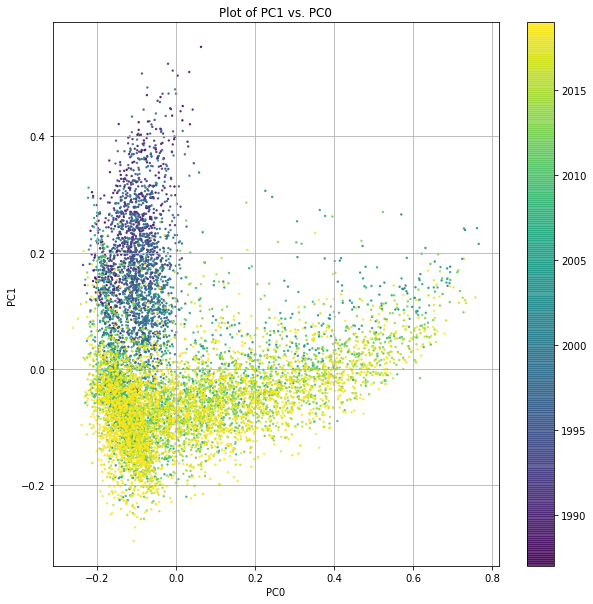

In [278]:
plot_comps(plot_data, 0, 1, hue='year', sample=None)

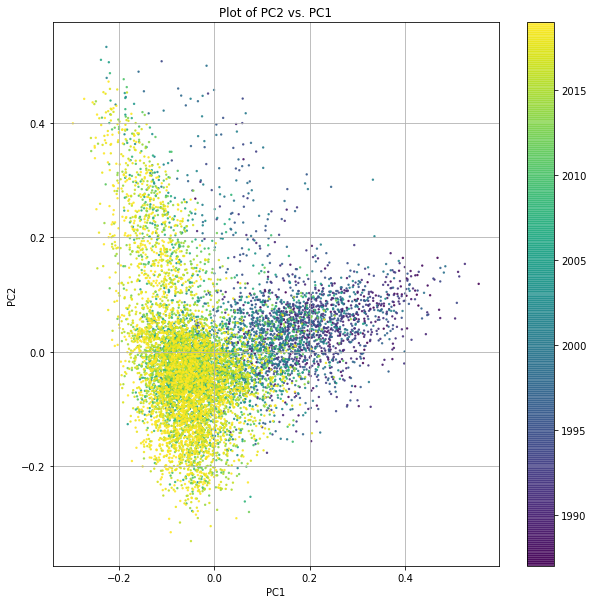

In [429]:
plot_comps(plot_data, 1, 2, hue='year', sample=None)

In [13]:
# join unlabeled tfidf array to labels
# columns are terms, index is doc_id
metrics = pd.DataFrame(
    tfidf.toarray(),
    columns=pd.Series(vectorizer.vocabulary_).sort_values().index,
    index=corpus.source_id
)

In [14]:
# extract top k words by tfidf for each doc
k = 4
top_words = metrics.apply(
    lambda x: metrics.columns[x.argsort()[-k:]].values, axis=1
)

## Clustering Analysis

In order to make the problem computationally feasible, we will perform hierarchical clustering on the reduced feature set produced by PCA.

In [430]:
# sklearn clustering of tfidf
# using Ward linkage, Euclidean distance
hclust = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0,
    affinity='euclidean',
    linkage='ward'
).fit(transformed)

In [431]:
''' Compute metrics from a cluster index
INPUT
    x: cluster index
    model: skl clustering model
    labels: df with indices to match cluster model and year col
OUTPUT
    formatted string for scipy.hierarchy.dendrogram labels
'''
def mean_year(x, model=hclust, labels=corpus):
    
    # initialize starting values
    trace = [x]
    n_samples = len(model.labels_)
    df = pd.DataFrame(model.children_)
    
    # add parent nodes:
    # node is parent if index >= n_samples
    i = 0
    while i < len(trace):
        node = trace[i]
        if node >= n_samples:
            for parent in df.iloc[trace[i]-n_samples,].values:
                trace.append(parent)
        i += 1
    
    # pull out original obs. and compute metrics
    parent_ids = [parent for parent in trace if parent < n_samples]
    avg_year = np.round(labels.iloc[parent_ids,].year.mean(), 2)
    std = np.round(labels.iloc[parent_ids,].year.std(), 2)
    
    return f'{avg_year} | {std} | ({len(parent_ids)})'


''' Plot dendrogram of clustering model
INPUT
    model: skl clustering model
    p: max number of leaf nodes to show
    labels: location of labels
    color_thresh: see scipy.hierarchy.dendrogram
    figsize: see plt.figure
OUTPUT
    None
Extended from skl documentation:
  https://scikit-learn.org/stable/auto_examples/cluster/
  plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-
  cluster-plot-agglomerative-dendrogram-py
''' 
def plot_dendrogram(model, p=30, labels=corpus,
                    color_thresh=None, figsize=(10,10)):
    
    # initialize starting values
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    # get counts for each cluster merge
    for i,row in enumerate(model.children_):
        for child in row:
            if child < n_samples:
                counts[i] += 1
            else:
                counts[i] += counts[child-n_samples]
    
    # generate linkage matrix
    linkage_mat = np.column_stack([
        model.children_,
        model.distances_,
        counts
    ])
    
    # plot dendrogram
    fig, ax = plt.subplots(figsize=figsize)
    hierarchy.dendrogram(
        linkage_mat,
        p=p, 
        truncate_mode='lastp', 
        orientation='left',
        color_threshold=color_thresh,
        leaf_label_func=mean_year
    )
    
    # text key
    plt.text(
        0.02, 0.92, 
        'Key:\n\nAvg. Year | StdDev | Count', 
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.5)
    )

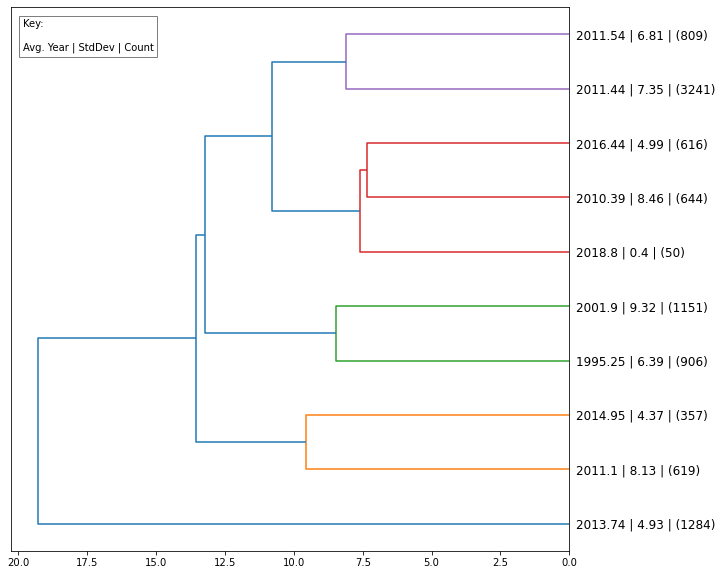

In [433]:
plot_dendrogram(hclust, p=10, color_thresh=10)

## Topic Modeling

We now perform topic modeling with Latent Dirichlet Allocation. Do to the large size of our dataset, it is imortant to select the "online" learning method from the sklearn implementation of LDA. This enables mini-batch learning that will speed up the training process. We could set the number of topics to match a cluster estimate from above, but we will instead increase to ten topics and see what kind of results are obtained.

In [303]:
# lda from sklearn
lda = LDA(n_components=10, learning_method='online', batch_size=128)
lda.fit(X)

LatentDirichletAllocation(learning_method='online')

In [304]:
# return the document-topic probabilities
topics = lda.transform(X)

In [310]:
topics.shape

(9677, 10)

In [309]:
# observe that all rows sum to 1
np.sum(topics, axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [321]:
# MAP topic assignment for each document
labels = np.argmax(topics, axis=1)
corpus['lda_topic'] = labels

# number of documents per topic
corpus.lda_topic.value_counts().sort_index()

0     112
1     955
2     404
3    2201
4    1467
5    1220
6     750
7     554
8    1073
9     941
Name: lda_topic, dtype: int64

In [330]:
# print out some sample titles from each topic
for i in range(lda.n_components):
    print(f'Topic {i}:')
    subset = corpus[corpus.lda_topic==i] \
        .sample(5) \
        .title \
        .values
    for title in subset:
        print(title)
    print('====================================')

Topic 0:
FaceSync: A Linear Operator for Measuring Synchronization of Video Facial Images and Audio Tracks
An EM Algorithm for Localizing Multiple Sound Sources in Reverberant Environments
A Classification-based Cocktail-party Processor
Noise Suppression Based on Neurophysiologically-motivated SNR Estimation for Robust Speech Recognition
Blind Separation of Radio Signals in Fading Channels
Topic 1:
How to Hedge an Option Against an Adversary: Black-Scholes Pricing is Minimax Optimal
Learning Optimal Reserve Price against Non-myopic Bidders
Repeated Games against Budgeted Adversaries
Learning to Predict Without Looking Ahead: World Models Without Forward Prediction
Dynamic Revenue Sharing
Topic 2:
Sanity Checks for Saliency Maps
ImageNet Classification with Deep Convolutional Neural Networks
Understanding Batch Normalization
Improving Neural Program Synthesis with Inferred Execution Traces
Knowledge Distillation by On-the-Fly Native Ensemble
Topic 3:
Parallelized Stochastic Gradient Des

In [343]:
# extract word distributions for each topic
lda_dist = pd.DataFrame(
    lda.components_,
    columns=vectorizer.get_feature_names()
)

In [401]:
# build results table to show top 10 words for each topic
# We could also randomize these based on the distributions
lda_results = lda_dist.apply(
    lambda x: lda_dist.columns[np.argsort(x)[-10:]].values,
    axis=1
)

# formatting into table
lda_results = lda_results.to_frame(name='Value') \
    .explode('Value') \
    .reset_index() 
lda_results = lda_results.rename(
    columns={lda_results.columns[0]:'Topic'}
)
lda_results['Term'] = lda_results.groupby('Topic').cumcount()
lda_results = lda_results.pivot(
    index='Topic', 
    columns='Term', 
    values='Value'
)

In [402]:
lda_results

Term,0,1,2,3,4,5,6,7,8,9
Topic,,,,,,,,,,
0,sha1_base64,source,using,10,ieee,noise,signal,latexit,time,cid
1,function,cid,reward,regret,action,time,algorithm,state,policy,learning
2,et,al,gradient,layer,training,deep,learning,network,networks,neural
3,96,problem,12,function,theorem,48,matrix,algorithm,107,cid
4,output,time,function,networks,learning,neural,input,network,cid,173
5,likelihood,bayesian,inference,cid,log,gaussian,models,data,distribution,model
6,algorithms,clustering,tree,problem,number,nodes,node,set,graph,algorithm
7,cell,cells,human,neurons,brain,time,response,visual,figure,model
8,test,2018,class,10,classiﬁcation,2017,set,training,data,learning


Some quick research shows that sha1_base64 likely references SHA-1, a cryptographic hash function. Notice also that the topic with this term has the smallest number of documents.

https://en.wikipedia.org/wiki/SHA-1